<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-Map-Parameters" data-toc-modified-id="Basic-Map-Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic Map Parameters</a></span></li><li><span><a href="#Basic-Map" data-toc-modified-id="Basic-Map-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic Map</a></span></li><li><span><a href="#Create-a-Split-Map" data-toc-modified-id="Create-a-Split-Map-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a Split Map</a></span></li><li><span><a href="#Reading-the-data-as-provided-by-the-gadget-(there-are-always-two-types-of-files---tracks-and-ratings-of-spots)" data-toc-modified-id="Reading-the-data-as-provided-by-the-gadget-(there-are-always-two-types-of-files---tracks-and-ratings-of-spots)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reading the data as provided by the gadget (there are always two types of files - tracks and ratings of spots)</a></span></li><li><span><a href="#Frequency-of-categories-1---5" data-toc-modified-id="Frequency-of-categories-1---5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Frequency of categories 1 - 5</a></span></li><li><span><a href="#Adding-tree--and-rubish-bin-locations-to-the-map" data-toc-modified-id="Adding-tree--and-rubish-bin-locations-to-the-map-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Adding tree- and rubish bin locations to the map</a></span></li><li><span><a href="#Grouping-of-markers-(not-really-useful-in-this-context)" data-toc-modified-id="Grouping-of-markers-(not-really-useful-in-this-context)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Grouping of markers (not really useful in this context)</a></span></li><li><span><a href="#The-resulting-HTML-file-should-be-visible-in-any-browser-(however,-icons-will-be-missing---fixible)" data-toc-modified-id="The-resulting-HTML-file-should-be-visible-in-any-browser-(however,-icons-will-be-missing---fixible)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>The resulting HTML file should be visible in any browser (however, icons will be missing - fixible)</a></span></li><li><span><a href="#Some-cleaning-up-if-needed" data-toc-modified-id="Some-cleaning-up-if-needed-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Some cleaning up if needed</a></span></li><li><span><a href="#Integrating-a-different-basemap-with-more-details" data-toc-modified-id="Integrating-a-different-basemap-with-more-details-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Integrating a different basemap with more details</a></span></li><li><span><a href="#For-later:-Experimenting-with-coloring-regions-or-neighborhoods" data-toc-modified-id="For-later:-Experimenting-with-coloring-regions-or-neighborhoods-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>For later: Experimenting with coloring regions or neighborhoods</a></span></li></ul></div>

In [86]:
# not all of these libraries are needed but for now let's load them to be prepared :-) 
from ipyleaflet import (Map, GeoData, WidgetControl, GeoJSON, basemaps, LocalTileLayer,
 LayersControl, Icon, Marker,basemap_to_tiles, Choropleth, AntPath,
 MarkerCluster, Heatmap, SearchControl, FullScreenControl, AwesomeIcon, 
 ScaleControl, MeasureControl, SplitMapControl, WMSLayer, Polygon, Choropleth)

In [87]:
# ipywidgets add user interactions to our notebook cells 
# read the docs https://ipywidgets.readthedocs.io/en/latest/
from ipywidgets import Text, HTML, IntSlider, ColorPicker, jslink, Layout
from branca.colormap import linear

In [88]:
# something to look into when wanting to color areas of a city or a region (Choropleth Maps)
# https://blog.datawrapper.de/choroplethmaps/
#import geopandas as gpd
#import json

In [89]:
# Pandas = derived from "Python and data analysis"
import pandas as pd  

## Basic Map Parameters 

In [90]:
# the centre of your map should be about the starting point of your mapping tour 
center = [48.231139, 16.374955]
zoom =16

# you can adjust the map size via ipwidgets *Layout* attribute  
basemap = basemaps.Esri.WorldStreetMap
layout = Layout(width='100%', height='600px')

"""
alternative options for basemaps are 
basemap = basemaps.Stamen.Watercolor
basemap = basemaps.Stamen.Toner
basemap = basemaps.Stamen.Terrain
etc 

"""

'\nalternative options for basemaps are \nbasemap = basemaps.Stamen.Watercolor\nbasemap = basemaps.Stamen.Toner\nbasemap = basemaps.Stamen.Terrain\netc \n\n'

## Basic Map 

In [91]:
m = Map(center=center, zoom=zoom, basemap = basemap, layout=layout)

# add user interaction / user information such as the scale of a map 
zoom_slider = IntSlider(description='Zoom level:', min=10, max=20, value=16)
jslink((zoom_slider, 'value'), (m, 'zoom'))

widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
m.add_control(widget_control1)
m.add_control(FullScreenControl())
m.add_control(ScaleControl(position='bottomleft', imperial = False))
m.add_control(LayersControl(position='topright'))

# this adds a nice feature to meassure the length of a path or a polygone area in square meters 
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'meters',
    primary_area_unit = 'sqmeters',
    completed_color = 'blue'
)
m.add_control(measure)
display (m)

Map(center=[48.231139, 16.374955], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Create a Split Map 

In [92]:
basemap = basemaps.Esri.WorldStreetMap
split_map = Map(center=center, zoom=zoom, layout=layout)

# create right and left layers
left_layer  = basemap_to_tiles(basemap=basemap)
right_layer = basemap_to_tiles(basemap=basemaps.Stamen.Toner) 

# create split control
control = SplitMapControl(left_layer=left_layer, right_layer=right_layer)

#add control to map
split_map.add_control(control)

# display map

zoom_slider = IntSlider(description='Zoom level:', min=10, max=20, value=16)
jslink((zoom_slider, 'value'), (m, 'zoom'))

widget_control1 = WidgetControl(widget=zoom_slider, position='topright')
split_map.add_control(widget_control1)
split_map.add_control(FullScreenControl())
split_map.add_control(ScaleControl(position='bottomleft', imperial = False))
split_map.add_control(LayersControl(position='topright')) 

display(split_map)

Map(center=[48.231139, 16.374955], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

## Reading the data as provided by the gadget (there are always two types of files - tracks and ratings of spots)

In [93]:
ratings=pd.read_csv('data/2020-10-12_rate_waste.csv', sep=';')
tracks=pd.read_csv('data/2020-10-12_track_waste.csv', sep=';')
print('number of track points: ', len (tracks))
tracks.tail(8)

number of track points:  500


,Date,Time,Raw_Time,Latitude,Longitude,Altitude,Sats,Sat_Speed,Precision
492,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
493,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
494,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
495,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
496,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
497,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
498,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2
499,121020,07:36:53,6365300,48.231945,16.371917,185.7,8,0.5,1.2


## Aspects of data quality

In [109]:
print('Frequency of same time records:      ', list(tracks.groupby(tracks['Raw_Time']).size().sort_values(ascending=False)) [0:20])
print('Frequency of same Longitude records: ', list(tracks.groupby(tracks['Latitude']).size().sort_values(ascending=False)) [0:20])
print('Distribution of number of satelites: ', list(tracks.groupby(tracks['Sats']).size().sort_values(ascending=False)) [0:20])

Frequency of same time records:       [24, 21, 18, 14, 13, 13, 13, 12, 9, 6, 6, 6, 5, 3, 2, 1, 1, 1, 1, 1]
Frequency of same Longitude records:  [24, 21, 18, 14, 13, 13, 13, 12, 9, 7, 6, 6, 5, 3, 3, 3, 2, 2, 2, 2]
Distribution of number of satelites:  [151, 128, 120, 86, 15]


In [137]:
satDistribution = tracks.groupby(tracks['Sats']).size().sort_values(ascending=False)
satNum =  list(satDistribution.keys())
satFreq = list(satDistribution)
satDens = list (zip (satNum, satFreq))
 
print('satellite density (sat-number, frequency): ', satDens)


satellite density (sat-number, frequency):  [(6, 151), (7, 128), (5, 120), (8, 86), (4, 15)]


<BarContainer object of 5 artists>

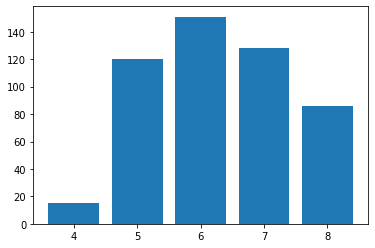

In [142]:
from matplotlib import pyplot as plt
plt.bar(satNum, satFreq)

## Use of categories (1 - 5)

In [168]:
cat=ratings.groupby(['Category']).size()
cat


Category
1    13
2     4
4     5
dtype: int64

In [256]:
catSeries = pd.Series([0,0,0,0,0,0])
catSeries = catSeries [1:6]
catSeries

1    0
2    0
3    0
4    0
5    0
dtype: int64

In [257]:
for x in cat.index:
    catSeries [x] = cat [x]
catSeries

1    13
2     4
3     0
4     5
5     0
dtype: int64

<BarContainer object of 5 artists>

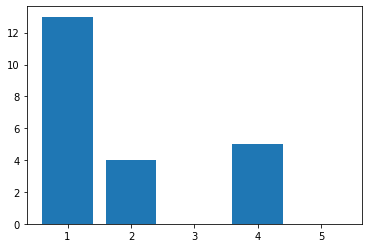

In [259]:

plt.bar(catSeries.index, catSeries)

In [260]:
# at this point we add some meaning to the categories 
tree_waste = ratings[ (ratings['Category'] == 1) | (ratings['Category'] == 2) ] 
bin_waste = ratings[ ratings['Category'] == 4] 
print ('number of polutted trees: ', len(tree_waste))
print ('number of overflowing bins: ', len(bin_waste))

number of polutted trees:  17
number of overflowing bins:  5


In [67]:
# a collection of points (GPS coordinates) needs to be provided as a list of lists, this is what this funciton does  
def location_converter (df): 
    markers = df.loc[:,{'Latitude','Longitude'}] #ouput dataframe 
    markers = markers.reindex(columns = ['Latitude','Longitude']) #
    markers = markers.to_records(index=False) #output array
    markers = list (markers) #output list of tuples
    markers = [list(i) for i in markers] # list of lists
    return markers


In [68]:
tracks.columns

Index(['Date', ' CET Time', ' Raw Time', 'Latitude', 'Longitude', 'Altitude',
       ' Num of Sats', ' Sat Speed', ' Precision'],
      dtype='object')

In [69]:
# calling the funnnction and checking outpu 
tree_pos = location_converter (tree_waste)
bin_pos = location_converter (bin_waste)
track_pos = location_converter (tracks)
tree_pos [0:2]

[[48.231136, 16.374966], [48.231619, 16.374845]]

In [70]:
import os
os.getcwd()

'/Users/me/code/notebooks/ipyleaflet'

## Adding tree- and rubish bin locations to the map 

In [71]:
print (get_ipython().__class__.__module__)

ipykernel.zmqshell


In [72]:
#trash_icon = AwesomeIcon (name='trash', marker_color='white', icon_color='black', spin=True)
#trash_icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-red.png', icon_size=[25, 40]) #red, green, yellow

bin_markers = []
tree_markers = [] 


#for jupyter notebook 
trash_icon = Icon(icon_url= 'icons/trashbin.png', icon_size=[30, 40])
tree_icon =  Icon(icon_url= 'icons/tree.png', icon_size=[30, 40])

'''
#for jupyter labs 
trash_icon = Icon(icon_url='files/'+os.getcwd().split('/')[-1]+'/icons/trashbin.png', icon_size=[30, 40])
tree_icon = Icon(icon_url='files/'+os.getcwd().split('/')[-1]+'/icons/tree.png', icon_size=[30, 40])
'''
#external icons 
#icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[38, 95], icon_anchor=[22,94])


# Just to see what os.path returns? 
'''
try: 
    print("File exist: ", os.path.isfile(foot_icon))
except:
    print(foot_icon)
'''


for i in range(len(bin_pos)):
    markertrash  = Marker(location=bin_pos[i], icon = trash_icon)
    m.add_layer(markertrash);
    #bin_markers = bin_markers + marker
    
    
for i in range(len(tree_pos)):
    markertree  = Marker(location=tree_pos[i], icon = tree_icon)
    m.add_layer(markertree);
    #tree_markers = tree_markers + marker
    
'''
for i in range(len(track_pos)):
    marker  = [Marker(location=track_pos[i], icon = foot_icon)]
    foot_markers = foot_markers + marker
   

bin_markers = tuple (bin_markers)
tree_markers = tuple (tree_markers)
#foot_markers = tuple (foot_markers)
''' 
 # creating the path of the mapping exercise 

ant_path = AntPath (
    locations=track_pos,     
    dash_array=[1, 10],
    delay=2000,
    color='#7590ba',
    pulse_color='#3f6fba',
    name='Trail')

m.add_layer(ant_path)

display (m) 

Map(bottom=5816168.0, center=[48.231139, 16.374955], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [73]:
# creating the path of the mapping exercise 

ant_path = AntPath (
    locations=track_pos,     
    dash_array=[1, 10],
    delay=2000,
    color='#7590ba',
    pulse_color='#3f6fba',
    name='Trail')

m.add_layer(ant_path)

display (m) 

Map(bottom=5816168.0, center=[48.231139, 16.374955], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Grouping of markers (not really useful in this context) 

In [20]:
"""
bin_layer = MarkerCluster(markers = bin_markers, name='Trash bins')
tree_layer = MarkerCluster(markers = tree_markers, name='Tree w. trash')

#foot_layer = MarkerCluster(markers = foot_markers, name='Trail')
# print(bin_layer)

m.add_layer(bin_layer) 
m.add_layer(tree_layer) 
m.add_layer(ant_path)
m
"""


"\nbin_layer = MarkerCluster(markers = bin_markers, name='Trash bins')\ntree_layer = MarkerCluster(markers = tree_markers, name='Tree w. trash')\n\n#foot_layer = MarkerCluster(markers = foot_markers, name='Trail')\n# print(bin_layer)\n\nm.add_layer(bin_layer) \nm.add_layer(tree_layer) \nm.add_layer(ant_path)\nm\n"

## The resulting HTML file should be visible in any browser (however, icons will be missing - fixible)

In [21]:
m.save('my_map.html', title='My Map')

## Some cleaning up if needed 

In [ ]:
m.clear_layers()

In [ ]:
m.remove_layer(bin_layer)
m.remove_layer(tree_layer)
m.remove_layer (ant_path)

## Integrating a different basemap with more details 

In [ ]:
from ipyleaflet import Map, WMSLayer, basemaps
#wmts = "http://maps.wien.gv.at/basemap/geolandbasemap/normal/google3857/{z}/{y}/{x}.png"

wms = WMSLayer(
    url='http://maps.wien.gv.at/basemap/geolandbasemap/normal/google3857/{z}/{y}/{x}.png',
    format='image/png',
    transparent=True,
    attribution='wait'
)

m.add_layer(wms)

m

## For later: Experimenting with coloring regions or neighborhoods 

In [ ]:
import csv 
from collections import defaultdict

In [ ]:
#the syntax is: mydict[key] = "value"
#mydict ["iphone 5S"] = 2013

def parse_csv_by_field(filename, fieldnames):
    print(fieldnames)
    d = defaultdict(list)
    with open(filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile, fieldnames)
        next(reader)  # remove header
        for row in reader:
            d[row ['bundesland']] = int (row ['measurement'])
    return dict(d)


area_data = parse_csv_by_field('data/area_data.csv', ['bundesland','measurement'])
area_data 
 
    

In [ ]:
m.clear_layers()

In [ ]:
import geopandas as gpd
import json 
states = gpd.read_file('geojson/laender.json')
print(states.head())

In [ ]:
geo_json_borders ['features'] [0] ['properties'] ['name']